In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [2]:
df = pd.read_csv('df-clean-03.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df

,Date,Maker,Sales,Identifier,Category
0,2010-02-15,Toshino,2143.0,RVFWTWSMNU,Air Conditioners
1,2010-02-15,Akaza,3515.0,VUQUQMHODG,Washers & Dryers
2,2010-02-15,Akaza,687.0,XVIOZZOUTN,Refrigerators
3,2010-02-15,Shimada,435.0,RBRMDIXXGL,Washers & Dryers
4,2010-02-15,Funami,726.0,BIBIOOIHA,Refrigerators
...,...,...,...,...,...
93166,2021-04-29,Shimada,1258.0,WVJTPVZKAQ,Ovens & Cooktops
93167,2021-04-29,Akaza,5422.0,VUQUQMHODG,Washers & Dryers
93168,2021-04-29,Hayashida,539.0,GCPKFKSEWG,Vacuum Cleaners
93169,2021-04-29,Furutani,10547.0,FVDHIZGQRC,Water Pumps


In [15]:
pvt_maker = pd.pivot_table(df, values='Sales', index='Date', columns=['Maker'], aggfunc=np.sum)

In [17]:
pvt_maker_tail3 = pvt_maker.drop(['Omuro', 'Funami', 'Furutani',
                            'Hayashida', 'Toshino', 'Akaza',
                            'Shimada', 'Yoshikawa', 'Sugiura',
                            'Matsumoto', 'Katayama', 'Nanase', 'Ikeda'],axis=1)

In [18]:
pvt_maker_tail3

Maker,Hisami,Kikuma,Okamoto
Date,,,
2010-02-15,749.0,NaN,322.0
2010-02-16,758.0,NaN,316.0
2010-02-17,753.0,NaN,307.0
2010-02-18,756.0,NaN,316.0
2010-02-19,758.0,NaN,317.0
...,...,...,...
2021-04-23,1147.0,798.0,1507.0
2021-04-26,1158.0,797.0,1480.0
2021-04-27,1185.0,802.0,1474.0


<AxesSubplot:xlabel='Date'>

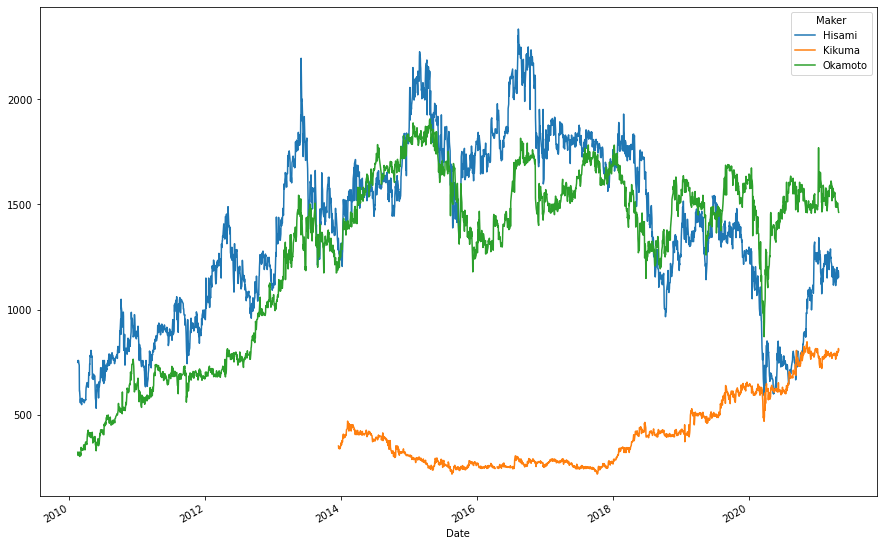

In [19]:
pvt_maker_tail3.plot(figsize=(15, 10))

In [24]:
pvt_maker_tail3 = pvt_maker_tail3.asfreq('D')

In [25]:
pvt_maker_tail3

Maker,Hisami,Kikuma,Okamoto
Date,,,
2010-02-15,749.0,NaN,322.0
2010-02-16,758.0,NaN,316.0
2010-02-17,753.0,NaN,307.0
2010-02-18,756.0,NaN,316.0
2010-02-19,758.0,NaN,317.0
...,...,...,...
2021-04-25,NaN,NaN,NaN
2021-04-26,1158.0,797.0,1480.0
2021-04-27,1185.0,802.0,1474.0


<AxesSubplot:xlabel='Date'>

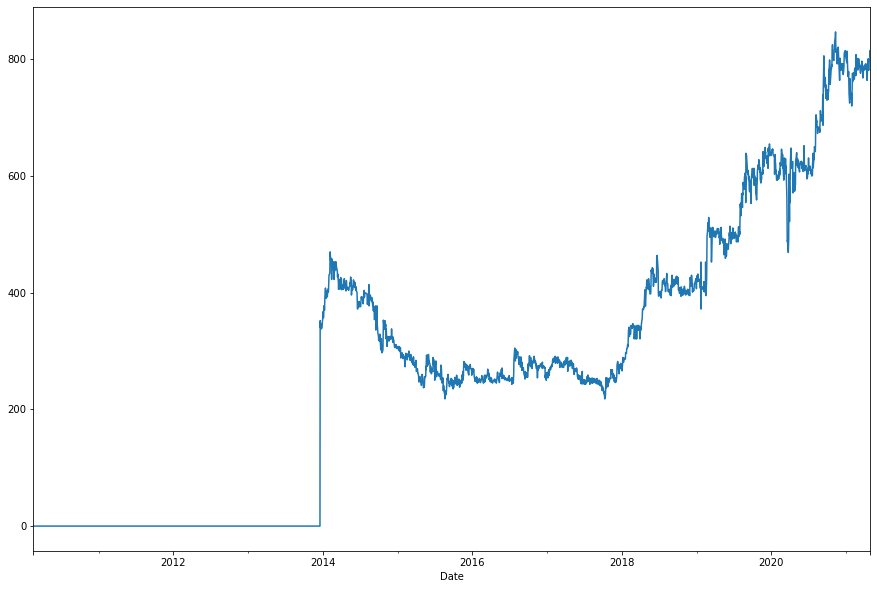

In [32]:
pvt_maker_tail3['Kikuma'].interpolate().fillna(0).plot(figsize=(15, 10))

In [33]:
pvt_maker_tail3['Hisami'] = pvt_maker_tail3['Hisami'].interpolate()
pvt_maker_tail3['Okamoto'] = pvt_maker_tail3['Okamoto'].interpolate()
pvt_maker_tail3['Kikuma'] = pvt_maker_tail3['Kikuma'].interpolate().fillna(0)

In [35]:
pvt_maker_tail3

Maker,Hisami,Kikuma,Okamoto
Date,,,
2010-02-15,749.000000,0.000000,322.0
2010-02-16,758.000000,0.000000,316.0
2010-02-17,753.000000,0.000000,307.0
2010-02-18,756.000000,0.000000,316.0
2010-02-19,758.000000,0.000000,317.0
...,...,...,...
2021-04-25,1154.333333,797.333333,1489.0
2021-04-26,1158.000000,797.000000,1480.0
2021-04-27,1185.000000,802.000000,1474.0


In [36]:
pvt_maker_tail3.index

DatetimeIndex(['2010-02-15', '2010-02-16', '2010-02-17', '2010-02-18',
               '2010-02-19', '2010-02-20', '2010-02-21', '2010-02-22',
               '2010-02-23', '2010-02-24',
               ...
               '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29'],
              dtype='datetime64[ns]', name='Date', length=4092, freq='D')

In [34]:
pvt_maker_tail3.isnull().sum()

Maker
Hisami     0
Kikuma     0
Okamoto    0
dtype: int64

In [37]:
train = pvt_maker_tail3.iloc[:len(pvt_maker_tail3)-12]
test = pvt_maker_tail3.iloc[len(pvt_maker_tail3)-12:]

from here

In [39]:
model1 = SARIMAX(train['Hisami'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results1 = model1.fit()
fcast1 = results1.predict(len(pvt_maker_tail3), len(pvt_maker_tail3)+30, typ='levels').rename('Hisami Prediction')

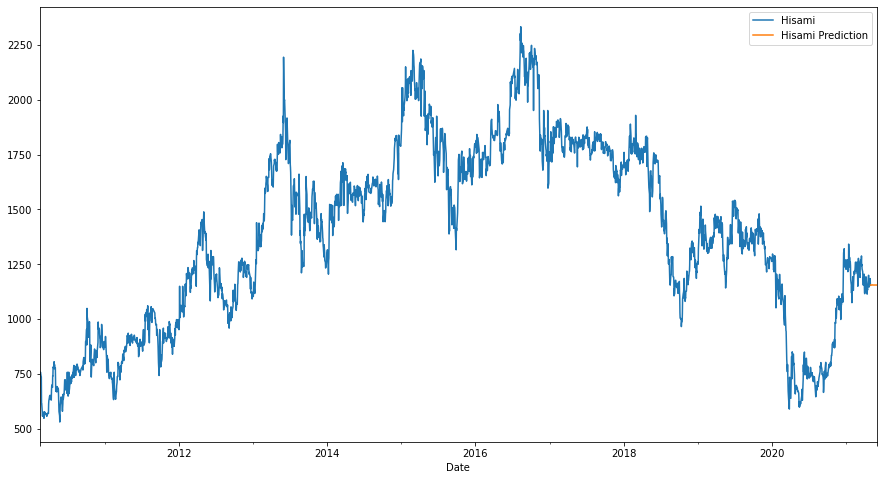

In [40]:
ax = pvt_maker_tail3['Hisami'].plot(legend=True, figsize=(15, 8))
fcast1.plot(legend=True)
ax.autoscale(axis='x', tight=True)

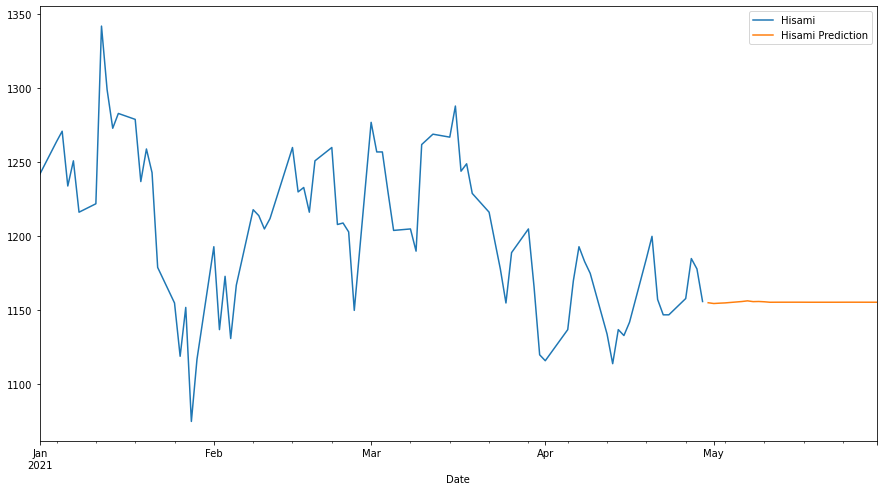

In [44]:
ax = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Hisami'].plot(legend=True, figsize=(15, 8))
fcast1.plot(legend=True)
ax.autoscale(axis='x', tight=True)

<AxesSubplot:xlabel='Date'>

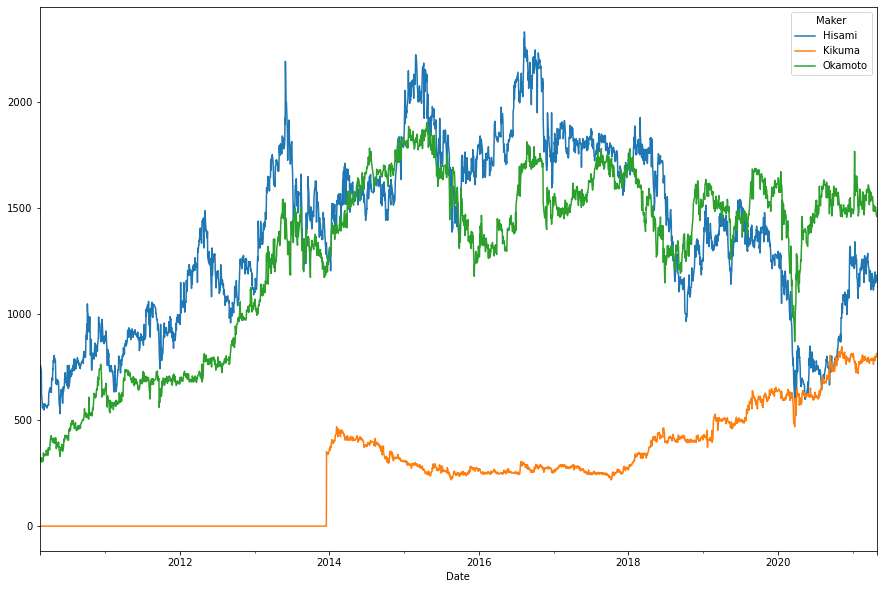

In [45]:
pvt_maker_tail3.plot(figsize=(15, 10))

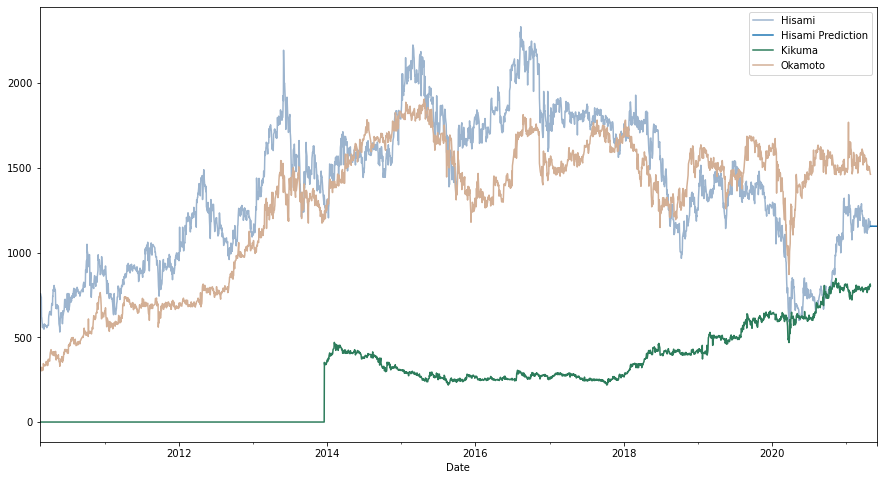

In [53]:
ax1 = pvt_maker_tail3['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True)
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
ax3.autoscale(axis='x', tight=True)

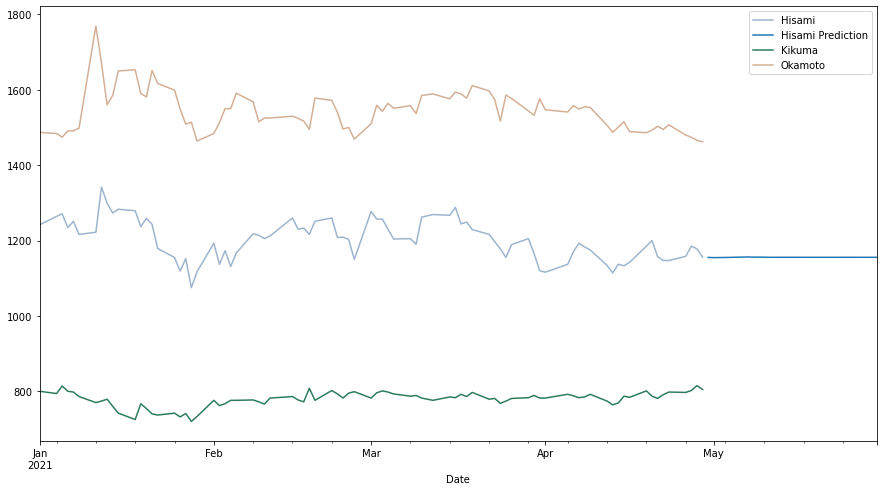

In [54]:
ax1 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True)
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
ax3.autoscale(axis='x', tight=True)

In [41]:
df[(df['Maker'] == 'Hisami') & (df['Date'].dt.year == 2021)]

,Date,Maker,Sales,Identifier,Category
7,2010-02-15,Hisami,749.0,VNZSEQOSNP,Vacuum Cleaners
39,2010-02-16,Hisami,758.0,VNZSEQOSNP,Vacuum Cleaners
89,2010-02-17,Hisami,753.0,VNZSEQOSNP,Vacuum Cleaners
110,2010-02-18,Hisami,756.0,VNZSEQOSNP,Vacuum Cleaners
147,2010-02-19,Hisami,758.0,VNZSEQOSNP,Vacuum Cleaners
...,...,...,...,...,...
93020,2021-04-23,Hisami,1147.0,VNZSEQOSNP,Vacuum Cleaners
93060,2021-04-26,Hisami,1158.0,VNZSEQOSNP,Vacuum Cleaners
93078,2021-04-27,Hisami,1185.0,VNZSEQOSNP,Vacuum Cleaners
93126,2021-04-28,Hisami,1178.0,VNZSEQOSNP,Vacuum Cleaners


In [43]:
df['Category'][(df['Maker'] == 'Hisami') & (df['Date'].dt.year == 2021)].value_counts()

Vacuum Cleaners    81
Name: Category, dtype: int64

In [56]:
model2 = SARIMAX(train['Kikuma'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results2 = model2.fit()
fcast2 = results2.predict(len(pvt_maker_tail3), len(pvt_maker_tail3)+30, typ='levels').rename('Kikuma Prediction')

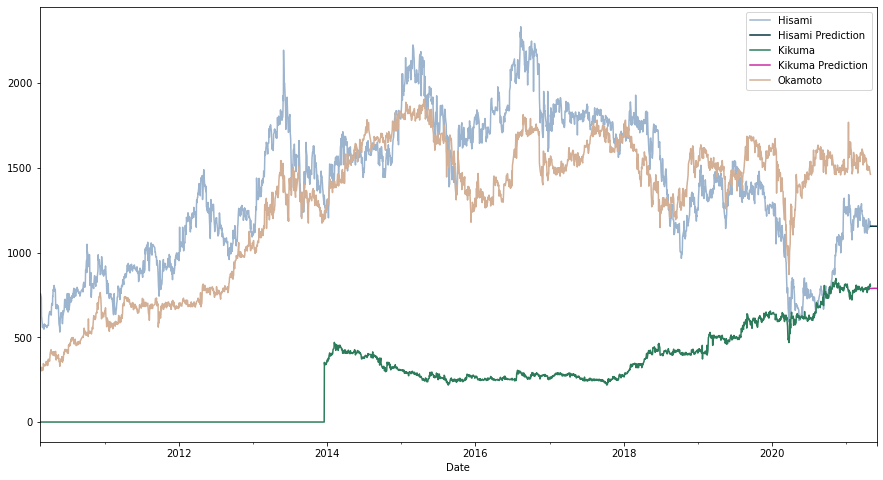

In [61]:
ax1 = pvt_maker_tail3['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True, color='#053541')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
fcast2.plot(legend=True, color='#c92ba7')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
ax3.autoscale(axis='x', tight=True)

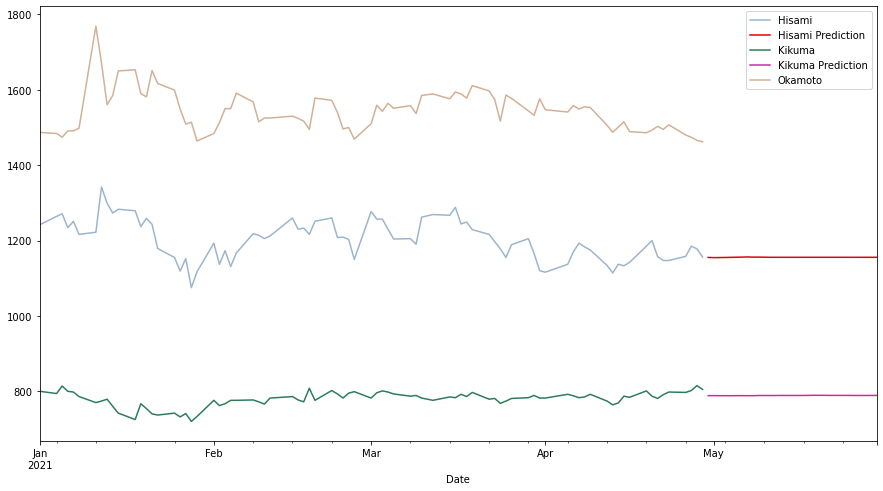

In [62]:
ax1 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True, color='#e10101')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
fcast2.plot(legend=True, color='#c92ba7')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
ax3.autoscale(axis='x', tight=True)

In [64]:
model3 = SARIMAX(train['Okamoto'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results3 = model3.fit()
fcast3 = results3.predict(len(pvt_maker_tail3), len(pvt_maker_tail3)+30, typ='levels').rename('Okamoto Prediction')

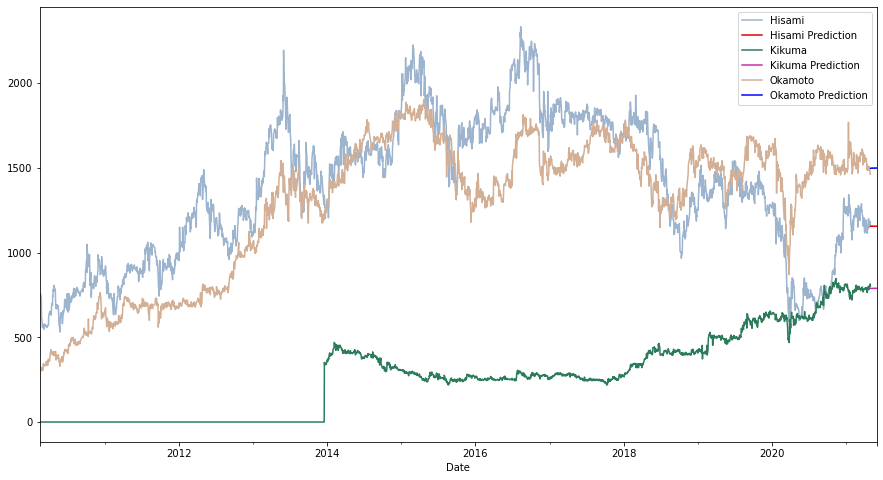

In [84]:
ax1 = pvt_maker_tail3['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True, color='#e10101')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
fcast2.plot(legend=True, color='#c92ba7')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
fcast3.plot(legend=True, color='#0000ff')
ax3.autoscale(axis='x', tight=True)

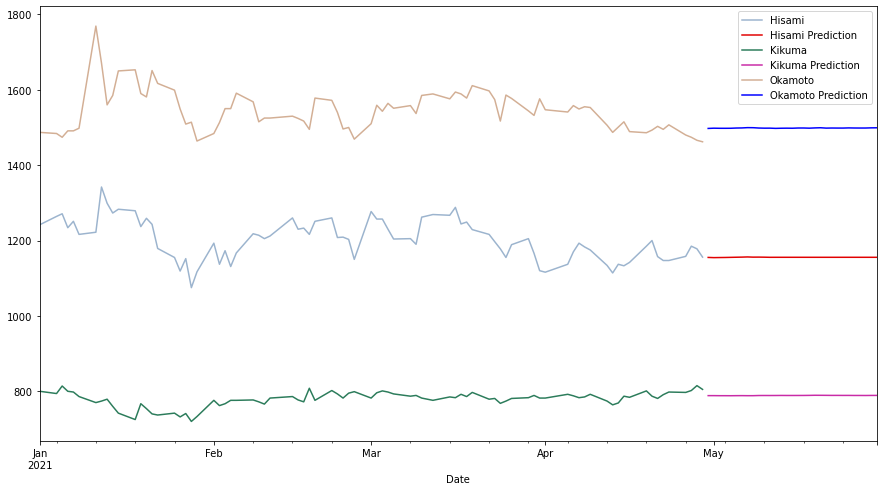

In [66]:
ax1 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True, color='#e10101')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
fcast2.plot(legend=True, color='#c92ba7')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
fcast3.plot(legend=True, color='#0000ff')
ax3.autoscale(axis='x', tight=True)

In [81]:
df['Category'][(df['Maker'] == 'Hisami') & (df['Date'].dt.year == 2021)].value_counts()

Vacuum Cleaners    81
Name: Category, dtype: int64

In [82]:
df['Category'][(df['Maker'] == 'Kikuma') & (df['Date'].dt.year == 2021)].value_counts()

Televisions    81
Name: Category, dtype: int64

In [83]:
df['Category'][(df['Maker'] == 'Okamoto') & (df['Date'].dt.year == 2021)].value_counts()

Televisions    81
Name: Category, dtype: int64

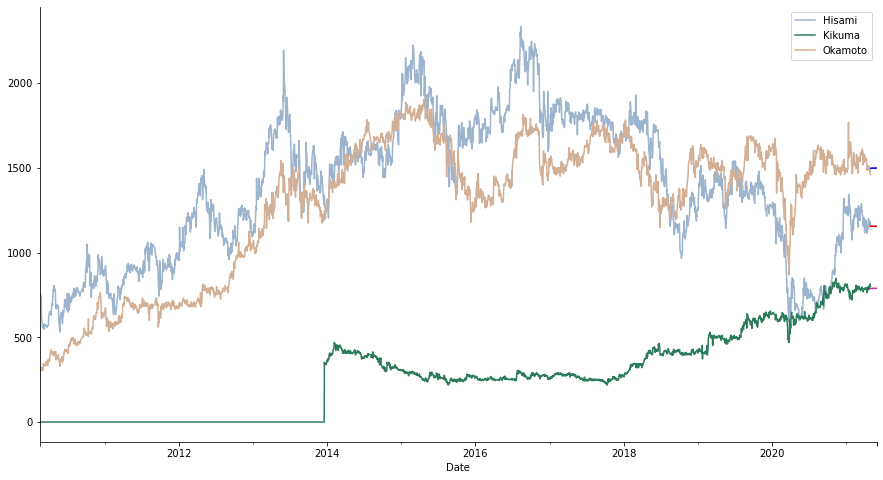

In [87]:
ax1 = pvt_maker_tail3['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(color='#e10101')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
fcast2.plot(color='#c92ba7')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
fcast3.plot(color='#0000ff')
ax3.autoscale(axis='x', tight=True)

for ax in (ax1, ax2, ax3):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

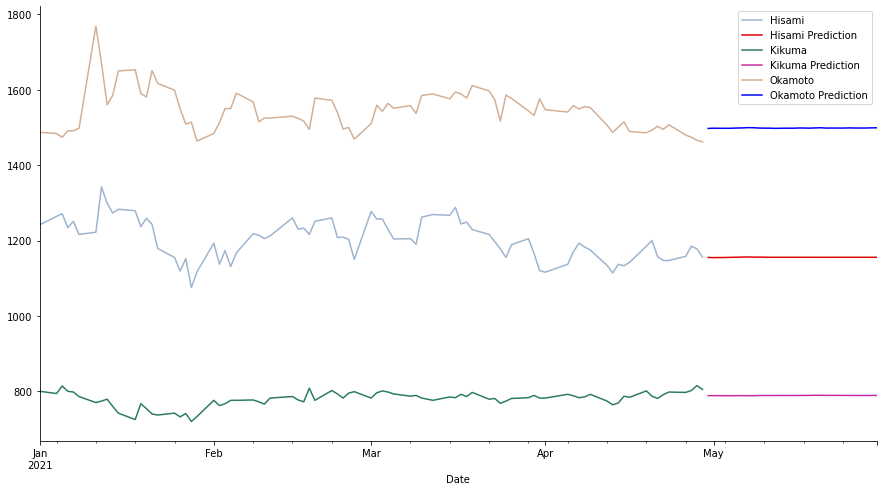

In [85]:
ax1 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True, color='#e10101')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
fcast2.plot(legend=True, color='#c92ba7')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
fcast3.plot(legend=True, color='#0000ff')
ax3.autoscale(axis='x', tight=True)

for ax in (ax1, ax2, ax3):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [91]:
fcast1.mean()

1155.5197074057742

In [92]:
fcast2.mean()

788.804163804821

In [93]:
fcast3.mean()

1498.4237634023275

In [94]:
pvt_maker_tail3

Maker,Hisami,Kikuma,Okamoto
Date,,,
2010-02-15,749.000000,0.000000,322.0
2010-02-16,758.000000,0.000000,316.0
2010-02-17,753.000000,0.000000,307.0
2010-02-18,756.000000,0.000000,316.0
2010-02-19,758.000000,0.000000,317.0
...,...,...,...
2021-04-25,1154.333333,797.333333,1489.0
2021-04-26,1158.000000,797.000000,1480.0
2021-04-27,1185.000000,802.000000,1474.0


In [96]:
pvt_maker_tail3['Hisami'].mean()

1382.7613123167157

In [101]:
pvt_maker['Kikuma'].mean()

411.00609289617483

In [102]:
pvt_maker_tail3['Okamoto'].mean()

1289.8599767839685